# Try out CLMM quadrupole measurement 

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
from astropy.table import Table
from numpy import random
import scipy
import matplotlib.pyplot as plt
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData
from clmm import Cosmology
from clmm.support import mock_data as mock

clmm.__version__

'1.12.5'

In [2]:
cosmo = Cosmology(H0=71.0, Omega_dm0=0.265 - 0.0448, Omega_b0=0.0448, Omega_k0=0.0)

### Read in mock catalogs and create galaca

In [3]:
phi = np.pi/2  ## rotation angle (don't know what it should be)

indir = 'axis_ratio_2_3/'
gamma1_ = np.load(f'catalogs/{indir}gamma1.npy')
gamma2_ = np.load(f'catalogs/{indir}gamma2.npy')

x_arcsec_ = np.load(f'catalogs/{indir}x_arcsec.npy')
y_arcsec_ = np.load(f'catalogs/{indir}y_arcsec.npy')

ra = x_arcsec_ / 3600.
dec = y_arcsec_ / 3600.

In [4]:
galcat = GCData()
galcat['ra'] = ra.flatten()
galcat['dec'] = dec.flatten()
galcat['e1'] = gamma1_.flatten()
galcat['e2'] = gamma2_.flatten()
galcat['z'] = np.zeros(len(ra.flatten())) + 0.8

galcat2 = GCData(np.copy(galcat))
galcat3 = GCData(np.copy(galcat))

In [5]:
galcat[0:3]

ra,dec,e1,e2,z
float64,float64,float64,float64,float64
-0.1375,0.1375,-0.0001238742439844591,0.0015250221728086307,0.8
-0.13472222222222222,0.1375,-9.485376092024044e-05,0.0015532780665121148,0.8
-0.13194444444444445,0.1375,-6.406121842896439e-05,0.0015815081966413323,0.8


In [6]:
cluster_id = "Awesome Cluster"

cluster_ra = 0
cluster_dec = 0

mdelta = 2e14
delta_mdef = 200
cluster_z = 0.47

### Create 3 GC objects and compute the radial profile
- `include_quadrupole = False` and `coordinate_system='celestial'`
- `include_quadrupole = True` and `coordinate_system='celestial'`
- `include_quadrupole = False` and `coordinate_system='euclidean'`

In [7]:
gc_object1 = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec, cluster_z, galcat, 
                               include_quadrupole=False,
                               coordinate_system='celestial')

gc_object2 = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec, cluster_z, galcat2, 
                               include_quadrupole=True,
                               coordinate_system='celestial')

gc_object3 = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec, cluster_z, galcat3, 
                               include_quadrupole=False,
                               coordinate_system='euclidean')

In [8]:
gc_object1.compute_tangential_and_cross_components(add=True, cosmo=cosmo, is_deltasigma=True, phi_major=phi)
gc_object2.compute_tangential_and_cross_components(add=True, cosmo=cosmo, is_deltasigma=True, phi_major=phi)
gc_object3.compute_tangential_and_cross_components(add=True, cosmo=cosmo, is_deltasigma=True, phi_major=phi)

(array([0.00339387, 0.00335976, 0.00332601, ..., 0.00332601, 0.00335976,
        0.00339387]),
 array([5.77079148e+12, 5.86916550e+12, 5.96946029e+12, ...,
        5.96946029e+12, 5.86916550e+12, 5.77079148e+12]),
 array([-4.68765605e+11, -4.78816222e+11, -4.88903209e+11, ...,
        -4.88903209e+11, -4.78816222e+11, -4.68765605e+11]))

In [9]:
bins = clmm.utils.make_bins(0.05,5,nbins=10, method='evenlog10width')

In [10]:
gc_object1.make_radial_profile(bins=bins, bin_units='Mpc', cosmo=cosmo, add=True );
gc_object2.make_radial_profile(bins=bins, bin_units='Mpc', cosmo=cosmo, add=True );
gc_object3.make_radial_profile(bins=bins, bin_units='Mpc', cosmo=cosmo, add=True );

/media/taeshin/research/CLMM/clmm/utils/statistic.py:97: RuntimeWarning: invalid value encountered in sqrt
  err_y = np.sqrt(stat_yerr2 + data_yerr2)
/media/taeshin/research/CLMM/clmm/utils/statistic.py:97: RuntimeWarning: invalid value encountered in sqrt
  err_y = np.sqrt(stat_yerr2 + data_yerr2)
/media/taeshin/research/CLMM/clmm/utils/statistic.py:97: RuntimeWarning: invalid value encountered in sqrt
  err_y = np.sqrt(stat_yerr2 + data_yerr2)


### Results and where the problem is...

- When not resquesting the computation of the quadrupole components, the `celestial` (blue) coordinates give the expected results for the monopole, while the `euclidean` (orange) is the wrong coordinate description

- When turning on the `include_quadrupole` option, and specifying `celestial` (green), the monopole is zero and exactly the same as with the `euclidean` option before --> the coordinate option may not be taken into account properly in the quadrupole case?


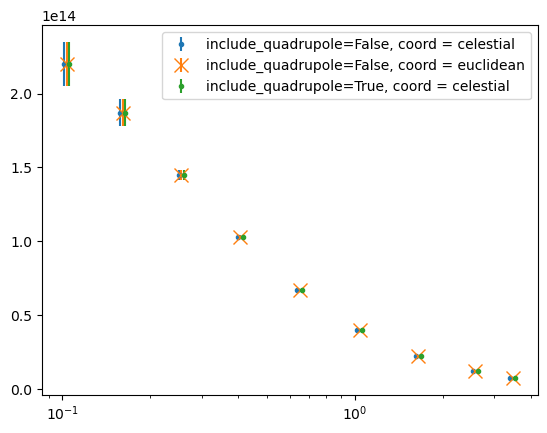

In [12]:
plt.errorbar(0.98*gc_object1.profile['radius'], gc_object1.profile['gt'], gc_object1.profile['gt_err'], 
             ls='', marker='.', label="include_quadrupole=False, coord = celestial")
plt.errorbar(1.00*gc_object3.profile['radius'], gc_object3.profile['gt'], gc_object3.profile['gt_err'], 
             ls='', marker='x', label="include_quadrupole=False, coord = euclidean", markersize=10)
plt.errorbar(1.02*gc_object2.profile['radius'], gc_object2.profile['gt'], gc_object2.profile['gt_err'], 
             ls='', marker='.', label="include_quadrupole=True, coord = celestial")
plt.legend()
plt.xscale('log')
#plt.yscale('log')

### Looking at quadrupole values

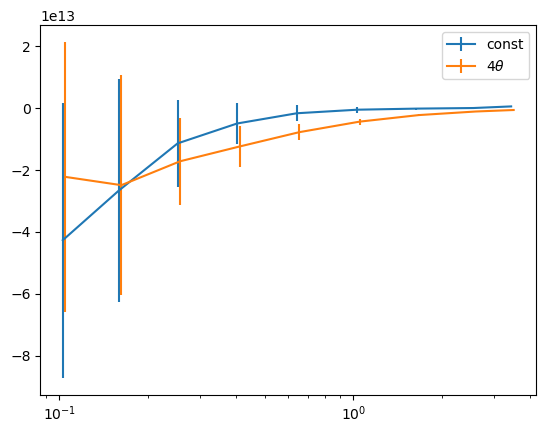

In [13]:
plt.errorbar(0.99*gc_object2.profile['radius'], gc_object2.profile['gconst'], gc_object2.profile['gconst_err'],
            label= 'const')
plt.errorbar(1.01*gc_object2.profile['radius'], gc_object2.profile['g4theta'],gc_object2.profile['g4theta_err'],
            label=r'4$\theta$')
plt.legend()
plt.xscale('log')